In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as mplot
import matplotlib.pyplot as plt 
import matplotlib.patches as patches

from matplotlib.colors import ListedColormap
import os
import subprocess
import sklearn

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score,  precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
 
from sklearn.tree import export_graphviz
import pydotplus
import seaborn as sns

import random
 


from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN


import tensorflow as tf
import keras
from keras import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.datasets import mnist 
 
from tensorflow.keras import layers, Input
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.metrics import AUC, Precision, Recall, F1Score
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import pickle 

import shap
import lime
from lime import lime_tabular
import random

import dalex as dx 

from tabulate import tabulate 

# Define custom metrics
recall = Recall()
precision = Precision()
f1_score = F1Score()
auc = AUC()



In [2]:
dataSetIndex = 6
needToMakePictureOfTrees = 0
''' ---------------------------------------------------------- '''
dataSetFilePath = ""
dataSetName = ""
dataSetResultDirectory = "./"

if(dataSetIndex == 0):
    dataSetFilePath = "./heartDisease/0_statLog_dataSet.csv"
    dataSetName = "SateLog_DataSet"
elif (dataSetIndex == 1):
    dataSetFilePath = "./heartDisease/1_heart_statlog_cleveland_hungary_final.csv"
    dataSetName = "ALL_StateLog_CleveLand_Hungary"
elif (dataSetIndex == 2):
    dataSetFilePath = "./heartDisease/2_cleveland.csv"
    dataSetName = "Cleveland"
elif (dataSetIndex == 3):
    dataSetFilePath = "./heartDisease/3_framingham.csv"
    dataSetName = "framingham"
elif (dataSetIndex == 4):
    dataSetFilePath = "./heartDisease/4_CardiacPrediction.xlsx"
    dataSetName = "CardiacPrediction"
elif (dataSetIndex == 5):
    dataSetFilePath = "./heartDisease/5_CardiacPredictionLessDimensions.xlsx"
    dataSetName = "CardiacPrediction"
elif (dataSetIndex == 6):
    dataSetFilePath = "./heartDisease/6_CardiacPredictionFewDimensions.xlsx"
    dataSetName = "CardiacPrediction"
else:
    dataSetFilePath = ""
    dataSetName = ""

if(dataSetIndex==4 or dataSetIndex==5 or dataSetIndex==6):
    #fileData = pd.read_excel(dataSetFilePath, sheet_name='CoroHeartDis')
    fileData = pd.read_excel(dataSetFilePath)
else:
    fileData = pd.read_csv(dataSetFilePath)

print("Shape of fileData: {}".format(fileData.shape))
print("Column Headings: {}".format(fileData.__dataframe__().column_names()))
print("Number of Records: {}".format(fileData.__dataframe__().num_rows()))


missingValues = fileData.isnull().any().sum()
print(f"\nNumber of Missing Values: {missingValues}")

num_rows_before = fileData.shape[0]
# Remove duplicate records based on all columns
fileData.drop_duplicates(inplace=True)
# Check the number of rows after removing duplicates
num_rows_after = fileData.shape[0]
# Print the number of duplicate records removed
num_duplicates_removed = num_rows_before - num_rows_after
print(f"Number of duplicate records removed: {num_duplicates_removed}")
 
 # Preprocess Steps from the ChatGPT
# 1. Handling Missing Values:
fileData = fileData.dropna()
print("Shape of fileData: {}".format(fileData.shape))              
#fileData.replace({'?': np.nan}).dropna().astype(float)
#fileData = fileData.fillna(0) 

fileData = fileData.fillna(0) 

print("Shape of fileData End: {}".format(fileData.shape))

finalResultTable = [ ['Index', 'Method', 'Accuracy %','Recall %','Precision %','F1 Score','AUC'], ]  


X = fileData.drop(fileData.__dataframe__().column_names()[-1], axis=1)  # Features
X = X.drop('Gender', axis=1)  # Features
#cols = ['Gender', 'Age','Annual-Family-Income', 'Cholesterol', 'Diabetes', 'Triglycerides', 'Red-Cell-Distribution-Width', 'X60-sec-pulse', 'Height', 'Albumin', 'Blood-Rel-Stroke', 'Blood-Rel-Diabetes', 'HDL', 'Moderate-work','Iron', 'Hemoglobin','Protein', 'SEQN'   ] 
#cols = ['Age','Gender','Blood-Rel-Stroke','Triglycerides','Blood-Rel-Diabetes','Cholesterol','Platelet-count','Diabetes','Albumin','Hemoglobin','Moderate-work','Diastolic','Protein','Height','X60-sec-pulse','White-Blood-Cells','Bilirubin','Hematocrit','HDL','Systolic' ] 
#X = fileData[cols]

Y = fileData[fileData.__dataframe__().column_names()[-1]]  # Labels

columns = fileData.__dataframe__().column_names() 
totalRecords = (fileData.__dataframe__().num_rows())

print("\n")
print("columns of x:: {} \n\n and features of X: {}".format(len(X.columns), X.columns))

dataSetResultDirectory = "./"
dataSetResultDirectory += ("DatasetResults_MLP_ADASYN_Feb24")
dataSetResultDirectory += "/"
if not os.path.isdir(dataSetResultDirectory):
    os.makedirs(dataSetResultDirectory)

dataSetName += "_{}".format(fileData.shape)



Shape of fileData: (37079, 40)
Column Headings: Index(['Gender', 'Age', 'X60-sec-pulse', 'Systolic', 'Diastolic', 'Weight',
       'Height', 'Body-Mass-Index', 'White-Blood-Cells', 'Lymphocyte',
       'Monocyte', 'Eosinophils', 'Basophils', 'Red-Blood-Cells', 'Hemoglobin',
       'Platelet-count', 'Segmented-Neutrophils', 'Hematocrit', 'Albumin',
       'ALP', 'AST', 'ALT', 'Cholesterol', 'Creatinine', 'Glucose', 'Iron',
       'LDH', 'Phosphorus', 'Bilirubin', 'Protein', 'Uric.Acid',
       'Triglycerides', 'Total-Cholesterol', 'HDL', 'Glycohemoglobin',
       'Moderate-work', 'Diabetes', 'Blood-Rel-Diabetes', 'Blood-Rel-Stroke',
       'CoronaryHeartDisease'],
      dtype='object')
Number of Records: 37079

Number of Missing Values: 0
Number of duplicate records removed: 0
Shape of fileData: (37079, 40)
Shape of fileData End: (37079, 40)


columns of x:: 38 

 and features of X: Index(['Age', 'X60-sec-pulse', 'Systolic', 'Diastolic', 'Weight', 'Height',
       'Body-Mass-Index', 'Wh

Target Column Name: CoronaryHeartDisease


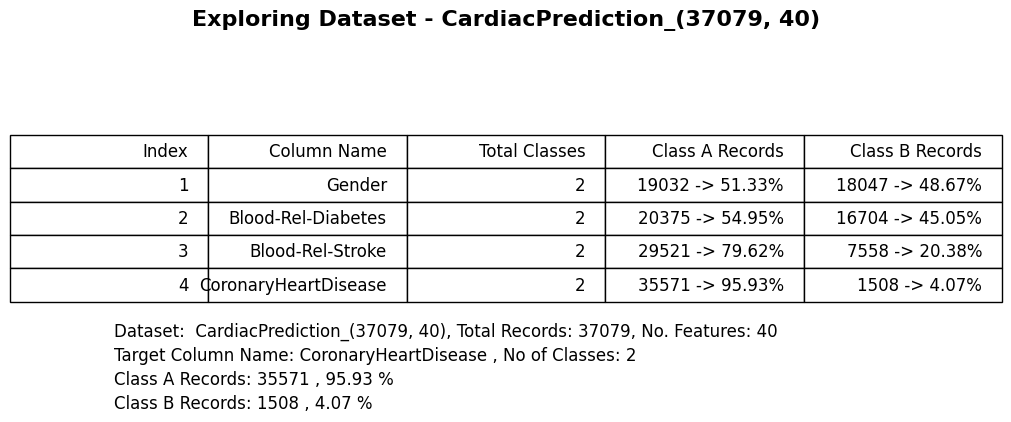

In [3]:
columns = fileData.__dataframe__().column_names() 
totalRecords = (fileData.__dataframe__().num_rows())
columnsForGraph = []
columnsForGraph.clear()
tableDataRow = []
for column in columns:
    singleColumnCount = fileData[column].value_counts()
    if(len(singleColumnCount) < 3):
        #print('Column Name:{} -> total records:{}'.format(column, totalRecords ) )
        #print('Number of classes:', len(singleColumnCount))
        #print('Class distribution:')
        #print(singleColumnCount)
        #print("np Array: {}".format(np.array(singleColumnCount)))
        #print("index: 0: {} -> {} %".format(np.array(singleColumnCount)[0], (np.array(singleColumnCount)[0] /totalRecords) * 100))
        #print("index: 1: {} -> {} %".format(np.array(singleColumnCount)[1], ( np.array(singleColumnCount)[1] /totalRecords) * 100))  
        #print('---------------------------------------------------------------')
        columnsForGraph.append(column)
 

tableDataRow = [
    ['Index', 'Column Name', 'Total Classes','Class A Records','Class B Records'],
    
]

indexx = 1
for column in columnsForGraph:
    singleColumnCount = fileData[column].value_counts()
    singleRowInTable = [] 
    singleRowInTable.append(indexx)
    singleRowInTable.append(column)
    singleRowInTable.append(len(singleColumnCount))
    cellDataString = "{} -> {:.2f}%".format(np.array(singleColumnCount)[0], (np.array(singleColumnCount)[0] /totalRecords) * 100)
    singleRowInTable.append((cellDataString)) 
    cellDataString = "{} -> {:.2f}%".format(np.array(singleColumnCount)[1], (np.array(singleColumnCount)[1] /totalRecords) * 100)
    singleRowInTable.append((cellDataString)) 
    indexx += 1
    tableDataRow.append(singleRowInTable) 

# Create the figure and axes
fig, ax = mplot.subplots() 
table = mplot.table(cellText=tableDataRow, loc='center') 

table.auto_set_font_size(False)
table.set_fontsize(12) 
table.scale(2.0, 2.0) 
print("Target Column Name: {}".format(columns[-1]))


dataSetString = "Dataset:  {}, Total Records: {}, No. Features: {}".format(dataSetName, totalRecords, fileData.__dataframe__().num_columns())
target ="Target Column Name: {} , No of Classes: {}".format(columns[-1], len(fileData[columns[-1]].value_counts()))
distributionOfTargetClassA ="Class A Records: {} , {:.2f} %".format(np.array(fileData[columns[-1]].value_counts())[0], (np.array(fileData[columns[-1]].value_counts())[0] /totalRecords) * 100)
distributionOfTargetClassB ="Class B Records: {} , {:.2f} %".format(np.array(fileData[columns[-1]].value_counts())[1], (np.array(fileData[columns[-1]].value_counts())[1] /totalRecords) * 100)

fig.text(-0.1, +0.25,  dataSetString, horizontalalignment='left', wrap=False , fontsize=12 )  
fig.text(-0.1, +0.20,  target, horizontalalignment='left', wrap=False  , fontsize=12 )   
fig.text(-0.1, 0.15,  distributionOfTargetClassA, horizontalalignment='left', wrap=False , fontsize=12  )   
fig.text(-0.1, 0.10,  distributionOfTargetClassB, horizontalalignment='left', wrap=False  , fontsize=12 )   
 
 
mplot.axis('off')
mplot.title(f'Exploring Dataset - {dataSetName}' ,fontsize=16, fontweight='bold') 

picturePath = "{}1.DataSet_analysis_{}.png".format(dataSetResultDirectory, dataSetName)
mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
#mplot.savefig('DataSet_analysis.png', dpi=300)
mplot.show()
mplot.close()
 

In [4]:
print("Shape of fileData: {} , target Len:{}".format(fileData.shape, len(Y)))
print("X: {} , Y:{}".format(X.shape, Y.shape))
#print("\n\nX: head:: \n{}".format(X.head()))
#print("\n\nY: head::\n {}".format(Y.head()))



rus = RandomUnderSampler(random_state=42)
smote = SMOTE(random_state=42)
ada = ADASYN(sampling_strategy='auto', random_state=42)
 
'''
# Undersample the majority class
X_train, y_train = rus.fit_resample(X_train, y_train)
X_test, y_test = rus.fit_resample(X_test, y_test)
'''
'''
# Oversample the minority class using SMOTE
X_train, y_train = smote.fit_resample(X_train, y_train)
X_test, y_test = smote.fit_resample(X_test, y_test) 
'''

X_resampled, y_resampled = ada.fit_resample(X, Y)


# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)
 

print("Target Column Name:: {} \n".format(fileData.__dataframe__().column_names()[-1]))

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



print("\n X Train: Shape:: {}".format(X_train.shape))
print(" X Test: Shape:: {}".format(X_test.shape))  
 
 
positiveClass =  0
negativeClass = 0
for i in y_train:
    if(i == 0):
        negativeClass += 1
    if(i == 1):
        positiveClass += 1
print("Train DataSet Positive Class Records:: {}".format(positiveClass)) 
print("Train DataSet Negative Class Records:: {}".format(negativeClass)) 
print("Train DataSet Total Records:: {}".format(positiveClass + negativeClass)) 

print("\n\n") 


positiveClass =  0
negativeClass = 0
for i in y_test:
    if(i == 0):
        negativeClass += 1
    if(i == 1):
        positiveClass += 1
print("Test DataSet Positive Class Records:: {}".format(positiveClass)) 
print("Test DataSet Negative Class Records:: {}".format(negativeClass)) 
print("Test DataSet Total Records:: {}".format(positiveClass + negativeClass)) 



Shape of fileData: (37079, 40) , target Len:37079
X: (37079, 38) , Y:(37079,)


Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  File "c:\Users\Mubashir Iqbal\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Target Column Name:: CoronaryHeartDisease 


 X Train: Shape:: (56559, 38)
 X Test: Shape:: (14140, 38)
Train DataSet Positive Class Records:: 28102
Train DataSet Negative Class Records:: 28457
Train DataSet Total Records:: 56559



Test DataSet Positive Class Records:: 7026
Test DataSet Negative Class Records:: 7114
Test DataSet Total Records:: 14140


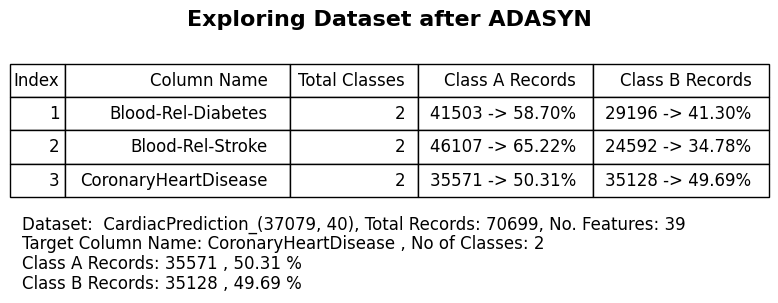

In [5]:
columnsForGraph = []
columnsForGraph.clear()
tableDataRow = []


# Concatenate feature and target data for both training and testing sets
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)
df_combined = pd.concat([df_train, df_test], axis=0, ignore_index=True)

columns = df_combined.__dataframe__().column_names() 
totalRecords = (df_combined.__dataframe__().num_rows())
for column in columns:
    singleColumnCount = df_combined[column].value_counts()
    if(len(singleColumnCount) < 3):
        #print('Column Name:{} -> total records:{}'.format(column, totalRecords ) )
        #print('Number of classes:', len(singleColumnCount))
        #print('Class distribution:')
        #print(singleColumnCount)
        #print("np Array: {}".format(np.array(singleColumnCount)))
        #print("index: 0: {} -> {} %".format(np.array(singleColumnCount)[0], (np.array(singleColumnCount)[0] /totalRecords) * 100))
        #print("index: 1: {} -> {} %".format(np.array(singleColumnCount)[1], ( np.array(singleColumnCount)[1] /totalRecords) * 100))  
        #print('---------------------------------------------------------------')
        columnsForGraph.append(column)
 
tableDataRow = [ ['Index', 'Column Name', 'Total Classes','Class A Records','Class B Records'], ]

indexx = 1
for column in columnsForGraph:
    singleColumnCount = df_combined[column].value_counts()
    singleRowInTable = [] 
    singleRowInTable.append(indexx)
    singleRowInTable.append(column)
    singleRowInTable.append(len(singleColumnCount))
    cellDataString = "{} -> {:.2f}%".format(np.array(singleColumnCount)[0], (np.array(singleColumnCount)[0] /totalRecords) * 100)
    singleRowInTable.append((cellDataString)) 
    cellDataString = "{} -> {:.2f}%".format(np.array(singleColumnCount)[1], (np.array(singleColumnCount)[1] /totalRecords) * 100)
    singleRowInTable.append((cellDataString)) 
    indexx += 1
    tableDataRow.append(singleRowInTable) 

 
# Determine the number of rows in the table (excluding the header)
num_rows = len(tableDataRow) + 1
# Calculate the desired figure size based on the number of rows
fig_width = 6  # Set the desired width of the figure
fig_height = num_rows * 0.5  # Adjust the scaling factor to control the height

fig, ax = mplot.subplots(figsize=(fig_width, fig_height)) 
table = mplot.table(cellText=tableDataRow, loc='center') 

table.auto_set_column_width(col=list(range(len(tableDataRow[0]))))

table.auto_set_font_size(False)
table.set_fontsize(12) 
table.scale(2.0, 2.0) 

dataSetString = "Dataset:  {}, Total Records: {}, No. Features: {}".format(dataSetName, totalRecords, df_combined.__dataframe__().num_columns())
target ="Target Column Name: {} , No of Classes: {}".format(columns[-1], len(df_combined[columns[-1]].value_counts()))
distributionOfTargetClassA ="Class A Records: {} , {:.2f} %".format(np.array(df_combined[columns[-1]].value_counts())[0], (np.array(df_combined[columns[-1]].value_counts())[0] /totalRecords) * 100)
distributionOfTargetClassB ="Class B Records: {} , {:.2f} %".format(np.array(df_combined[columns[-1]].value_counts())[1], (np.array(df_combined[columns[-1]].value_counts())[1] /totalRecords) * 100)

fig.text(-0.1, +0.10,  dataSetString, horizontalalignment='left', wrap=False , fontsize=12 )  
fig.text(-0.1, +0.02,  target, horizontalalignment='left', wrap=False  , fontsize=12 )   
fig.text(-0.1, -0.06,  distributionOfTargetClassA, horizontalalignment='left', wrap=False , fontsize=12  )   
fig.text(-0.1, -0.14,  distributionOfTargetClassB, horizontalalignment='left', wrap=False  , fontsize=12 )   

remarks = "You need to distribute the target class in equal number of records in training-set."
#fig.text(-0.2, -0.15,  remarks, horizontalalignment='left', wrap=True ,fontsize=12, fontweight='bold' )   
 
mplot.axis('off')
mplot.title(f'Exploring Dataset after ADASYN' ,fontsize=16, fontweight='bold') 
picturePath = "{}02.DataSet_analysis_After_dataAugmentation_{}.png".format(dataSetResultDirectory, dataSetName)
mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
#mplot.savefig(picturePath,  dpi=300 )
mplot.show()
mplot.close()

In [6]:
def makeCorrelationPic(correlationMatrix, numberOfTopFeatures, targetColumnName):     
    correlation_values = correlationMatrix.abs()
    sorted_correlation = correlation_values.unstack().sort_values(ascending=False)
    sorted_correlation = sorted_correlation[sorted_correlation != 1.0]

    num_features = numberOfTopFeatures  # Number of top features to display
    top_features = sorted_correlation.head(num_features)
    print("Top", num_features, "features based on correlation:")
    print(top_features)
 
    top_features = correlationMatrix.abs().nlargest(numberOfTopFeatures, targetColumnName)[targetColumnName].index
    top_correlation_matrix = correlationMatrix.loc[top_features, top_features]

    mplot.figure(figsize=(10, 8))
    sns.heatmap(top_correlation_matrix, annot=True, cmap='coolwarm')
    # Set the title of the plot
    mplot.title('Correlation Heatmap ({})'.format(dataSetName))
    
    picturePath = "Correlation_Matrix_DateSetName_{}.png".format(dataSetName)
    mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
    mplot.show()
    mplot.close()

def makeConfusionMatrixPic(method, dataSet, classifierObj , X_test, y_test, predicted_Y):
    display = ConfusionMatrixDisplay.from_estimator(classifierObj, X_test, y_test, display_labels=['Healthy', "Heart Disease"], cmap=mplot.cm.Blues) #, normalize="true"
    display.ax_.set_title("Confusion Matrix ({} Model)".format(method))
    ax_.set_xlabel('\nPredicted Values')
    ax_.set_ylabel('Actual Values ')


    accuracyString ="Accuracy {}: {:.2f}".format(method, accuracy_score(y_test, predicted_Y)*100.0 ) 
    recallString =  'Recall {}: {:.2f}'.format(method, recall_score(y_test, predicted_Y) * 100.0)
    precisionString = 'Precision {}: {:.2f}'.format(method, precision_score(y_test, predicted_Y) * 100.0) 
    dataSetString = "Dataset: {}".format(dataSet)

    
    if(classifierObj.n_features_in_ > 10):
        featureListString = 'Total Features: {}'.format(classifierObj.n_features_in_) 
    else:
        featureListString = 'Features: {}'.format(classifierObj.feature_names_in_) 
    
    display.figure_.text(0.010, -0.05,  accuracyString, horizontalalignment='left', wrap=False )  
    display.figure_.text(0.010, -0.09,  recallString, horizontalalignment='left', wrap=False )      
    display.figure_.text(0.010, -0.13,  precisionString, horizontalalignment='left', wrap=False ) 
    display.figure_.text(0.010, -0.17,  dataSetString, horizontalalignment='left', wrap=False ) 
    display.figure_.text(0.010, -0.28,  featureListString, horizontalalignment='left', wrap=False ) 
 
    picturePath = "{}Confusion_Matrix_{}_{}.png".format(dataSetResultDirectory, method, dataSetName)
    mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
    #print("{} Confusion Matrix saved:: path: {}".format(method, picturePath))
    #os.startfile(picturePath)
    mplot.show()
    mplot.close()


In [7]:
X_train_normalized = tf.keras.utils.normalize(X_train, axis=1)
X_test_normalized = tf.keras.utils.normalize(X_test, axis=1)

scaler = StandardScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.fit_transform(X_test) 
# Our vectorized labels

X_train_f32 = np.asarray(X_train).astype(np.float32)  #.astype('float32').reshape((-1,1))
X_test_f32 = np.asarray(X_test).astype(np.float32)

#y_train_scaler = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test_scaler = np.asarray(y_test).astype('float32').reshape((-1,1))

 

# Separate features and target variable
features = X_train_scaler # data.iloc[:, :-1]
target = np.asarray(y_train).astype('float64').reshape((-1,1))  #data['CoronaryHeartDisease']
 
 

print("X_train shape: {}   and dType: {}".format(X_train.shape, len(X_train.columns)))
print("X_train_scaler shape: {}   and dType: {}".format(X_train_scaler.shape, X_train_scaler.dtype))
print("X_test_scaler shape: {}   and dType: {}".format(X_test_scaler.shape, X_test_scaler.dtype)) 


print("y_train shape: {}   and dType: {}".format(y_train.shape, y_train.dtype))  
print("y_test_scaler shape: {}   and dType: {}".format(y_test_scaler.shape, y_test_scaler.dtype))  


print("features shape: {}   and dType: {}".format(features.shape, features.dtype))
print("target shape: {}   and dType: {}".format(target.shape, target.dtype)) 

X_train shape: (56559, 38)   and dType: 38
X_train_scaler shape: (56559, 38)   and dType: float64
X_test_scaler shape: (14140, 38)   and dType: float64
y_train shape: (56559,)   and dType: int64
y_test_scaler shape: (14140, 1)   and dType: float32
features shape: (56559, 38)   and dType: float64
target shape: (56559, 1)   and dType: float64


In [8]:
tf.keras.backend.clear_session()
# Define the attention layer
print("Number of Node: {}".format(features.shape[1]//2))
print("Number 2 of Node: {}".format(features.shape[1]//1.5))


class AttentionLayer(tf.keras.layers.Layer):
    def call(self, inputs, **kwargs):
        q, v = inputs
        attention = tf.keras.layers.Attention()([q, v])
        return attention

# Build the model
input_layer = Input(shape=(features.shape[1],))

# Traditional neural network part
x = layers.Dense(features.shape[1]*2, activation='relu')(input_layer)
x = layers.Dense(features.shape[1], activation='relu')(x) 
x = layers.Dense(features.shape[1], activation='relu')(x) 
#x = layers.BatchNormalization()(x)
 
#attention = AttentionLayer()([x, x]) 
#x = layers.Concatenate()([x, attention])
x = layers.Dense(features.shape[1], activation='relu')(x)
#x = layers.BatchNormalization()(x)
x = layers.Dense(features.shape[1]//2, activation='relu')(x)
# Output layer
output_layer = layers.Dense(1, activation='sigmoid')(x)



model = tf.keras.Model(inputs=input_layer, outputs=output_layer) 
optimizer = AdamW(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', recall, precision, f1_score, auc])

  
# Display the model summary
model.summary()
 


Number of Node: 19
Number 2 of Node: 25.0
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 38)]              0         
                                                                 
 dense (Dense)               (None, 76)                2964      
                                                                 
 dense_1 (Dense)             (None, 38)                2926      
                                                                 
 dense_2 (Dense)             (None, 38)                1482      
                                                                 
 dense_3 (Dense)             (None, 38)                1482      
                                                                 
 dense_4 (Dense)             (None, 19)                741       
                                                                 
 dense_5 (Dense)   

In [9]:
numberOfEpochs = 40
batchSizeOfTraining = 25
history = 0
history = model.fit(features, target, epochs=numberOfEpochs, batch_size=batchSizeOfTraining)

model2 = model


Epoch 1/40


2263/2263 [==============================] - 15s 5ms/step - loss: 0.3117 - accuracy: 0.8707 - recall: 0.8860 - precision: 0.8584 - f1_score: 0.6639 - auc: 0.9387
Epoch 2/40
2263/2263 [==============================] - 9s 4ms/step - loss: 0.2421 - accuracy: 0.9031 - recall: 0.9284 - precision: 0.8828 - f1_score: 0.6639 - auc: 0.9614
Epoch 3/40
2263/2263 [==============================] - 10s 5ms/step - loss: 0.2035 - accuracy: 0.9213 - recall: 0.9482 - precision: 0.8989 - f1_score: 0.6642 - auc: 0.9712
Epoch 4/40
2263/2263 [==============================] - 9s 4ms/step - loss: 0.1805 - accuracy: 0.9327 - recall: 0.9575 - precision: 0.9114 - f1_score: 0.6652 - auc: 0.9764
Epoch 5/40
2263/2263 [==============================] - 11s 5ms/step - loss: 0.1611 - accuracy: 0.9408 - recall: 0.9646 - precision: 0.9201 - f1_score: 0.6687 - auc: 0.9801
Epoch 6/40
2263/2263 [==============================] - 9s 4ms/step - loss: 0.1462 - accuracy: 0.9473 - recall: 0.9677 - precision: 0.9

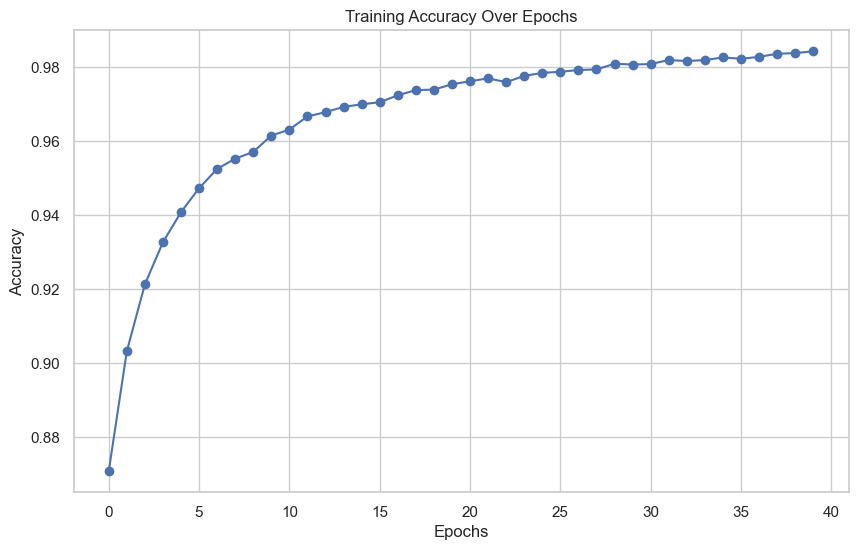

In [10]:
# Plotting training accuracy
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], marker='o', linestyle='-', color='b')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
picturePath = "{}3.Model_training_Accuracy_{}_epoches_{}.png".format(dataSetResultDirectory, dataSetName, numberOfEpochs)
plt.savefig(picturePath,  dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [11]:
# Evaluate the model using the evaluate method
y_test_float64 = np.asarray(y_test).astype('float64').reshape((-1,1))  #data['CoronaryHeartDisease']

loss, accuracy, recall_value, precision_value, f1_score_value, auc_value = model2.evaluate(X_test_scaler, y_test_float64)

# Print the results
print('Test loss: {}'.format(loss*100))
print('Test accuracy: {}'.format(accuracy*100))
print('Test recall: {}'.format(recall_value*100))
print('Test precision: {}'.format(precision_value*100))
print('Test F1 score: {}'.format(f1_score_value*100))
print('Test AUC: {}'.format(auc_value*100))


picturePath = "{}Model_Evaluation_{}_{}_Epoch_{}.png".format(dataSetResultDirectory, "Testing_Accuracy", dataSetName, numberOfEpochs)


442/442 [==============================] - 2s 4ms/step - loss: 0.1611 - accuracy: 0.9566 - recall: 0.9722 - precision: 0.9422 - f1_score: 0.7576 - auc: 0.9819
Test loss: 16.109952330589294
Test accuracy: 95.65770626068115
Test recall: 97.22459316253662
Test precision: 94.22069191932678
Test F1 score: [75.7561]
Test AUC: 98.18773865699768


442/442 [==============================] - 1s 2ms/step
MLP with Attention layer Confusion Matrix saved:: path: ./DatasetResults_MLP_ADASYN_Feb24/Model_Evaluation_MLP with Attention layer_CardiacPrediction_(37079, 40)_Epoch_40.png


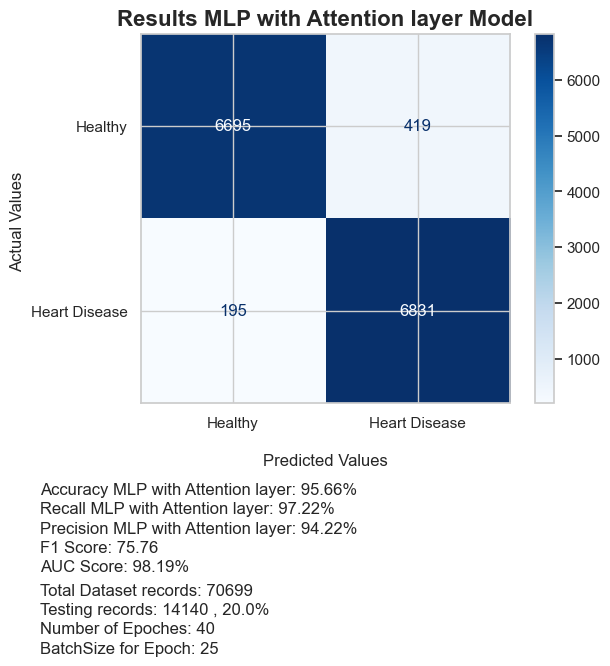

In [12]:
threshold = 0.5  # Adjust the threshold as needed
binary_predictions = (model2.predict(X_test_scaler) > threshold).astype(int)

cm = confusion_matrix(y_test_float64, binary_predictions)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Heart Disease'])
display.plot(cmap=plt.cm.Blues, values_format=".4g" ) 


method = "MLP with Attention layer"
display.ax_.set_title("Results {} Model".format(method),fontsize=16, fontweight='bold')
display.ax_.set_xlabel('\nPredicted Values')
display.ax_.set_ylabel('Actual Values ')

accuracyString ="Accuracy {}: {:.2f}%".format(method, accuracy*100.0 ) 
recallString =  'Recall {}: {:.2f}%'.format(method, recall_value* 100.0)
precisionString = 'Precision {}: {:.2f}%'.format(method, precision_value * 100.0) 
f1String = "F1 Score: {:.2f}".format(f1_score_value[0] * 100.0)
featureListString = "AUC Score: {:.2f}%".format(auc_value * 100.0)
totaldataSetString = "Total Dataset records: {}".format((len(features)+len(X_test_scaler)))
testingdataSetString = "Testing records: {} , {:.1f}%".format(len(X_test_scaler), ( ( len(X_test_scaler) / (len(features)+len(X_test_scaler)) )*100.0  ))
numberOfEpochsString = "Number of Epoches: {}".format(numberOfEpochs)
batchSizeOfTrainingString = "BatchSize for Epoch: {}".format(batchSizeOfTraining)

display.figure_.text(0.010, -0.08,  accuracyString, horizontalalignment='left', wrap=False )  
display.figure_.text(0.010, -0.12,  recallString, horizontalalignment='left', wrap=False )      
display.figure_.text(0.010, -0.16,  precisionString, horizontalalignment='left', wrap=False ) 
display.figure_.text(0.010, -0.20,  f1String, horizontalalignment='left', wrap=False ) 
display.figure_.text(0.010, -0.24,  featureListString, horizontalalignment='left', wrap=False ) 
display.figure_.text(0.010, -0.29,  totaldataSetString, horizontalalignment='left', wrap=False ) 
display.figure_.text(0.010, -0.33,  testingdataSetString, horizontalalignment='left', wrap=False ) 
display.figure_.text(0.010, -0.37,  numberOfEpochsString, horizontalalignment='left', wrap=False ) 
display.figure_.text(0.010, -0.41,  batchSizeOfTrainingString, horizontalalignment='left', wrap=False ) 
 
picturePath = "{}Model_Evaluation_{}_{}_Epoch_{}.png".format(dataSetResultDirectory, method, dataSetName, numberOfEpochs)
mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
print("{} Confusion Matrix saved:: path: {}".format(method, picturePath))

mplot.show()
mplot.close()


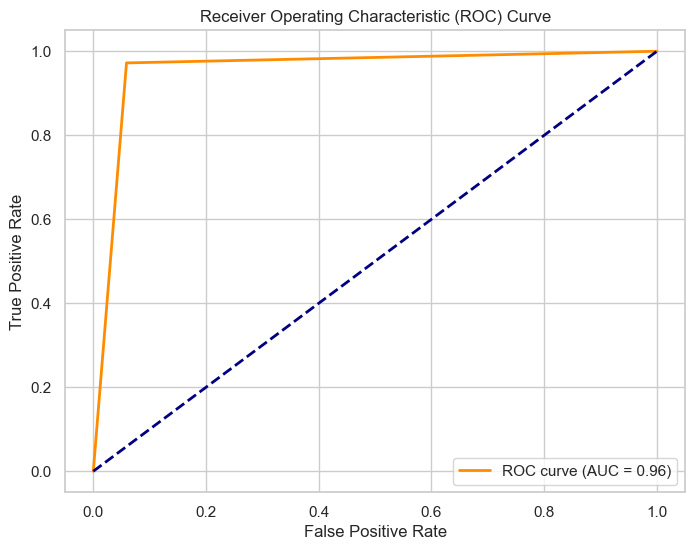

In [13]:
# Calculate AUC
auc_score = roc_auc_score(y_test, binary_predictions)
# Calculate ROC Curve
fpr, tpr, _ = roc_curve(y_test, binary_predictions)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

picturePath = "{}Model_Evaluation_ROC_{}_{}_Epoch_{}.png".format(dataSetResultDirectory, method, dataSetName, numberOfEpochs)
mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')

plt.show()
plt.close()




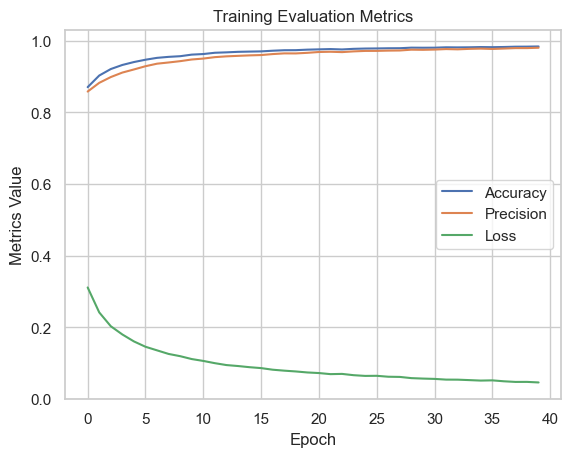

In [14]:
# Plot Testing accuracy
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['precision'], label='Precision')
plt.plot(history.history['loss'], label='Loss')

# Set plot labels and title
plt.title('Training Evaluation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Metrics Value')

# Add legend
plt.legend()

picturePath = "{}Model_Training_Evaluation_{}_{}_Epoch_{}.png".format(dataSetResultDirectory, method, dataSetName, numberOfEpochs)
mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')

plt.show()
plt.close()


In [15]:
percentage = 0.07
numberOfFeatures = int(len(features) *percentage)
print("Total Features: {} -> Selected for SHAP:: {}".format(len(features), numberOfFeatures))
featuresForShap = X_train.columns #features[0:numberOfFeatures]
#print(" Features Name: {}".format(  featuresForShap))

numberOftest = int(len(X_test_scaler) * percentage)
print("Total Test: {} -> Selected for SHAP:: {}".format(len(X_test_scaler), numberOftest))
testForShap = X_test_scaler[0:len(featuresForShap)]
testForShap = X_test_scaler[0:numberOftest]
#print(" testForShap Name: {}".format(  testForShap))



Total Features: 56559 -> Selected for SHAP:: 3959
Total Test: 14140 -> Selected for SHAP:: 989


# shap.DeepExplainer

In [16]:
deepExplainer = shap.DeepExplainer(model, features[0:int(numberOftest*20)])
deepTestValues =  testForShap[0:int(numberOftest)]
deepShap_values = deepExplainer.shap_values(deepTestValues)



Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [17]:
deepShap_array = np.array(deepShap_values) 
mean_abs_shap_values = np.mean(np.abs(deepShap_array), axis=(0, 1)) 
sorted_indices = np.argsort(mean_abs_shap_values)[::-1] 
sorted_feature_names = np.array(X.columns.to_list())[sorted_indices]

sorted_shap_values = deepShap_array[:, sorted_indices].T
#print(sorted_shap_values) 
deepShapValuesPlot = mean_abs_shap_values[sorted_indices]
print("DeepExplainer Top Feature List")
print("--------------------------------")
for feature, mean_shap_value in zip(sorted_feature_names, mean_abs_shap_values[sorted_indices]):
    print(f"{feature}, {mean_shap_value}") 



DeepExplainer Top Feature List
--------------------------------
Age, 0.11203036064340367
Diabetes, 0.04194543219250729
Cholesterol, 0.03975494616351543
Blood-Rel-Stroke, 0.03947759298119947
Triglycerides, 0.034318309552599305
Albumin, 0.02990106582446682
Hematocrit, 0.02985483151198339
Moderate-work, 0.02811680780074502
Height, 0.027388288303855347
Blood-Rel-Diabetes, 0.027306512745082445
Bilirubin, 0.02725392286564129
Protein, 0.027061691357022178
Platelet-count, 0.026033618248453787
Diastolic, 0.02523873115332926
Systolic, 0.02267577064813553
Phosphorus, 0.021459001609906055
Red-Blood-Cells, 0.019968149130064648
ALP, 0.019062875333762632
Hemoglobin, 0.019031431009970252
Basophils, 0.018766817155314853
X60-sec-pulse, 0.018740132934228257
Monocyte, 0.01834395360008765
Iron, 0.018326336709398438
Eosinophils, 0.018191988077142583
Total-Cholesterol, 0.018025391798718184
LDH, 0.017986357689736925
Uric.Acid, 0.01769531205505478
White-Blood-Cells, 0.016519949068362048
Creatinine, 0.015804599

In [18]:
shap.summary_plot(deepShap_values, deepTestValues, feature_names=featuresForShap, show=False)
ax = mplot.gca() 
ax.set_title("XAI SHAP DeepExplainer" ,fontsize=16, fontweight='bold')     
dataSetString = "Dataset:  {}".format(dataSetName)
testingDatasetString ="length of SHAP dataset: {}".format(len(testForShap))
ax.figure.text(0.020, -0.05,  dataSetString, horizontalalignment='left', wrap=False )  
ax.figure.text(0.020, -0.09,  testingDatasetString, horizontalalignment='left', wrap=False )   

picturePath = "{}XAI_SHAP_DeepExplainer_{}_{}_Sorted_numberOfSamples_{}.png".format(dataSetResultDirectory, method, dataSetName, len(testForShap))
mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
#mplot.show()
#os.startfile(picturePath)
mplot.close()


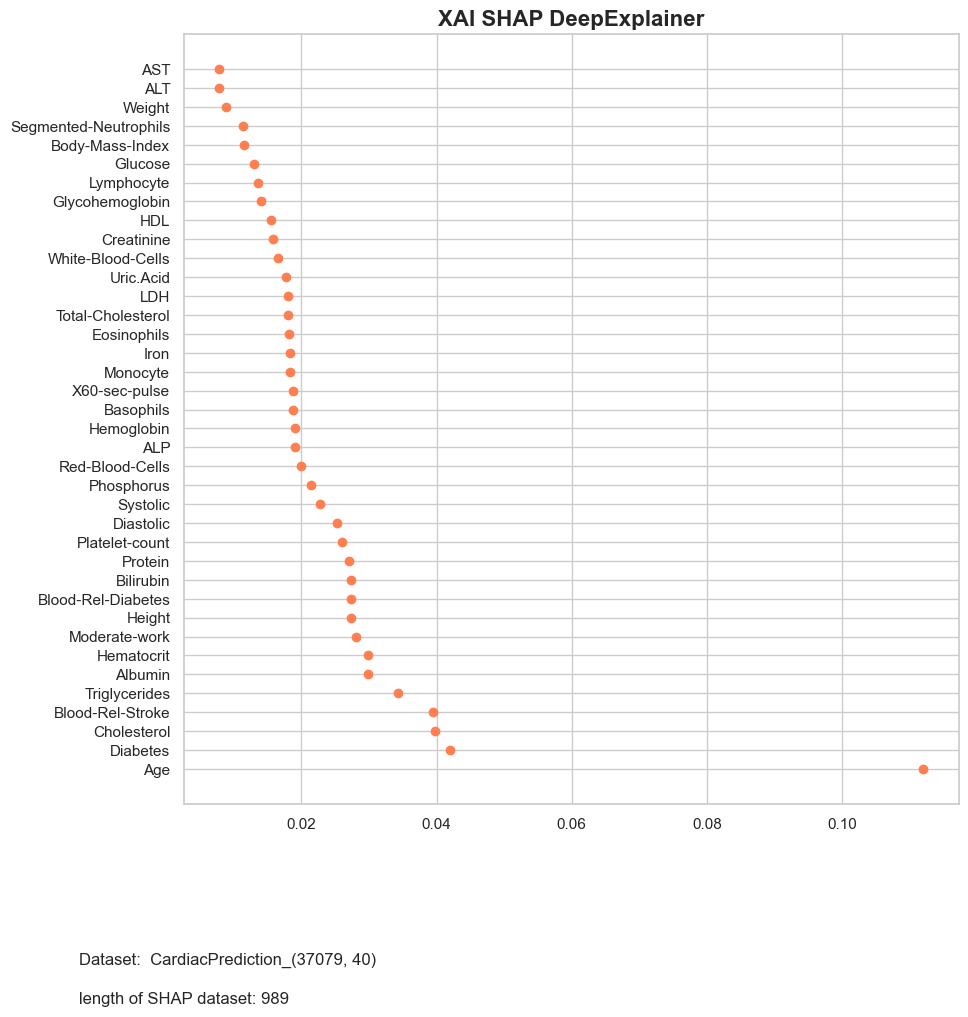

In [19]:
# Plot the summary plot for the top 15 features
plt.figure(figsize=(10, 10))
plt.scatter(deepShapValuesPlot, sorted_feature_names, color='coral')
ax = mplot.gca() 
ax.set_title("XAI SHAP DeepExplainer" ,fontsize=16, fontweight='bold')     
dataSetString = "Dataset:  {}".format(dataSetName)
testingDatasetString ="length of SHAP dataset: {}".format(len(testForShap))

ax.figure.text(0.020, -0.05,  dataSetString, horizontalalignment='left', wrap=False )  
ax.figure.text(0.020, -0.09,  testingDatasetString, horizontalalignment='left', wrap=False )   


picturePath = "{}XAI_SHAP_DeepExplainer_Bar_{}_{}_Sorted_numberOfSamples_{}.png".format(dataSetResultDirectory, method, dataSetName, len(testForShap))
mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
mplot.show()
#os.startfile(picturePath)
mplot.close()

In [20]:
# Plot the summary plot for the top 15 features
plt.figure(figsize=(15, 8))
shap.summary_plot(deepShap_array, feature_names=sorted_feature_names, plot_type="violin", show=False)
ax = mplot.gca() 
ax.set_title('MLP Model deepExplainer Violin Plot' ,fontsize=16, fontweight='bold')     
dataSetString = "Dataset:  {}".format(dataSetName)
testingDatasetString ="length of SHAP dataset: {}".format(len(testForShap))
ax.figure.text(0.020, -0.05,  dataSetString, horizontalalignment='left', wrap=False )  
ax.figure.text(0.020, -0.09,  testingDatasetString, horizontalalignment='left', wrap=False )   
picturePath = "{}XAI_SHAP_DeepExplainer_Bar_{}_{}_Sorted_numberOfSamples_{}.png".format(dataSetResultDirectory, method, dataSetName, len(testForShap))
mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
#mplot.show()
#os.startfile(picturePath)
mplot.close()






<Figure size 1500x800 with 0 Axes>

In [21]:
import seaborn as sns
import numpy as np

# Plot the summary plot for the top 15 features
plt.figure(figsize=(12, 6))
#sns.violinplot(x=sorted_feature_names, y=deepShapValuesPlot, palette='pastel')
sns.violinplot(x=sorted_feature_names, y=deepShapValuesPlot, inner="quartile", palette="pastel") 
ax = plt.gca()  # Use plt instead of mplot
ax.set_title('MLP Model deepExplainer Violin Plot', fontsize=16, fontweight='bold')
dataSetString = "Dataset:  {}".format(dataSetName)
testingDatasetString = "length of SHAP dataset: {}".format(len(testForShap))
ax.figure.text(0.020, -0.05, dataSetString, horizontalalignment='left', wrap=False)
ax.figure.text(0.020, -0.09, testingDatasetString, horizontalalignment='left', wrap=False)


plt.xticks(range(len(sorted_feature_names)), sorted_feature_names, rotation=45, ha='right')

picturePath = "{}XAI_SHAP_DeepExplainer_ViolinPlot_{}_{}_Sorted_numberOfSamples_{}.png".format(dataSetResultDirectory, method, dataSetName, len(testForShap))
plt.savefig(picturePath, dpi=300, bbox_inches='tight')
#plt.show()
# os.startfile(picturePath)
plt.close()

 



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



In [22]:
plt.figure(figsize=(15, 6))
sns.swarmplot(y=deepShapValuesPlot, x=sorted_feature_names, palette="muted", size=10) 
plt.title('MLP Model with SHAP (XAI) Beeswarm Plot')
plt.ylabel('SHAP Values')
plt.xticks(rotation=45, ha='right')

picturePath = "{}XAI_SHAP_DeepExplainer_SNS_Beeswarmplot_{}_{}_numberOfSamples_{}.png".format(dataSetResultDirectory, method, dataSetName, len(testForShap))
plt.savefig(picturePath,  dpi=300, bbox_inches='tight')
#plt.show()
plt.close()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



[ 0 35 21 37 30 17 16 34  5 36]

--------------------------------------------------
Top SHAP Explainer values:
Age, 0.11203036064340378
Diabetes, 0.04194543219250731
Cholesterol, 0.03975494616351548
Blood-Rel-Stroke, 0.03947759298119948
Triglycerides, 0.03431830955259933
Albumin, 0.029901065824466846
Hematocrit, 0.02985483151198338
Moderate-work, 0.028116807800745075
Height, 0.027388288303855327
Blood-Rel-Diabetes, 0.027306512745082438
--------------------------------------------------



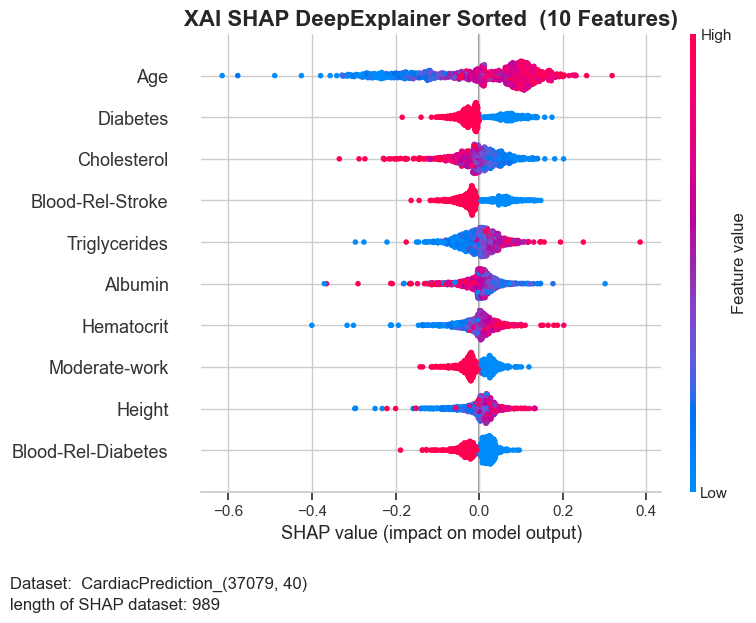

In [35]:
howManyFeatures = 10
# Calculate feature importance based on the mean absolute SHAP values
feature_importance =  np.abs(deepShap_values).mean(axis=(0, 1))
top_features_indices = np.argsort(feature_importance)[::-1][:howManyFeatures]
# Select only the top features and corresponding SHAP values
print(top_features_indices)
featureNamesSHAP = X.columns[top_features_indices]
top_features = testForShap[:, top_features_indices]
top_shap_values = deepShap_values[0][:, top_features_indices]

print("\n--------------------------------------------------") 
print("Top SHAP Explainer values:")
for i in range(len(top_features_indices)):
    feature_index = top_features_indices[i]
    feature_name = X.columns[feature_index]
    shap_value = np.mean(np.abs(top_shap_values[:, i])) 
    print(f"{feature_name}, {shap_value}")
 
print("--------------------------------------------------\n") 
 

# Plot the summary plot for the top 15 features
shap.summary_plot(top_shap_values, top_features, feature_names=featureNamesSHAP, show=False)
ax = mplot.gca() 
ax.set_title("XAI SHAP DeepExplainer Sorted  ({} Features)".format(howManyFeatures) ,fontsize=16, fontweight='bold')     
dataSetString = "Dataset:  {}".format(dataSetName)
testingDatasetString ="length of SHAP dataset: {}".format(len(testForShap)) 
ax.figure.text(0.020, -0.05,  dataSetString, horizontalalignment='left', wrap=False )  
ax.figure.text(0.020, -0.09,  testingDatasetString, horizontalalignment='left', wrap=False )   

picturePath = "{}XAI_SHAP_DeepExplainer2_Bar_{}_{}_Sorted_numberOfSamples_{}.png".format(dataSetResultDirectory, method, dataSetName, len(testForShap))
mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
mplot.show()
#os.startfile(picturePath)
mplot.close()

In [24]:
feature_names = X.columns.tolist() 
 
top_10_feature_names = [feature_names[i] for i in top_features_indices]
top_10_shap_values = deepShap_values[0][:, top_features_indices] 
# Create a DataFrame for visualization
df_top_10 = pd.DataFrame(data=top_10_shap_values, columns=top_10_feature_names)
# Plotting with Seaborn's violinplot
plt.figure(figsize=(15, 6))
sns.violinplot(data=df_top_10, inner="quartile", palette="muted") 
plt.title('SHAP (DeepExplainer) Violin Plot')
plt.xticks(rotation=45, ha='right')

picturePath = "{}XAI_SHAP_DeepExplainer2_SNS_Violinplot_{}_{}_numberOfSamples_{}.png".format(dataSetResultDirectory, method, dataSetName, len(testForShap))
plt.savefig(picturePath,  dpi=300, bbox_inches='tight') 
#plt.show()
plt.close()


# Plotting a Bubble Chart
plt.figure(figsize=(12, 6))

for i, feature in enumerate(top_10_feature_names):
    size = np.abs(df_top_10[feature]) * 100  # Adjust the scale as needed
    plt.scatter(x=[i] * len(df_top_10), y=df_top_10[feature], s=size, label=feature, alpha=0.6)
 
plt.title('SHAP (DeepExplainer) Bubble Chart')
plt.xlabel('Feature Index')
plt.ylabel('SHAP Values')
plt.xticks(range(len(top_10_feature_names)), top_10_feature_names, rotation=45, ha='right')
#plt.legend()
picturePath = "{}XAI_SHAP_DeepExplainer2_SNS_BubbleChart_{}_{}_numberOfSamples_{}.png".format(dataSetResultDirectory, method, dataSetName, len(testForShap))
plt.savefig(picturePath,  dpi=300, bbox_inches='tight')
#plt.show()
plt.close()

# Bubble Chart   
top_10_avg_shap_values = feature_importance[top_features_indices]

# Calculate the scale for bubble size based on the average values compared to others
size_scale = np.abs(top_10_avg_shap_values) / np.max(np.abs(top_10_avg_shap_values))
# Create a DataFrame for visualization
df_top_10_avg_shap = pd.DataFrame({'Feature': top_10_feature_names, 'Average SHAP Value': top_10_avg_shap_values})
# Plotting a Bubble Chart for top 10 average SHAP values
plt.figure(figsize=(12, 6))
size = size_scale * 1000  # Adjust the scale as needed
plt.scatter(x=range(len(df_top_10_avg_shap)), y=df_top_10_avg_shap['Average SHAP Value'], s=size, alpha=0.6)

plt.title('SHAP (DeepExplainer) Bubble Chart Average')
plt.xlabel('Feature Index')
plt.ylabel('Average SHAP Values')
plt.xticks(range(len(df_top_10_avg_shap)), df_top_10_avg_shap['Feature'], rotation=45, ha='right')
picturePath = "{}XAI_SHAP_DeepExplainer2_SNS_BubbleChartAverage_{}_{}_numberOfSamples_{}.png".format(dataSetResultDirectory, method, dataSetName, len(testForShap))
plt.savefig(picturePath,  dpi=300, bbox_inches='tight')
#plt.show()
plt.close()


# Plotting a boxplot for the top 10 features
plt.figure(figsize=(12, 6))
x_axis_range = (-0.10, 0.10)  # Adjust the range as needed
sns.boxplot(data=df_top_10, orient='v', palette='Set2')
plt.title('SHAP (DeepExplainer) Box Plot')
plt.xlabel('SHAP Values')
plt.ylabel('Features')
plt.xticks(range(len(df_top_10_avg_shap)), df_top_10_avg_shap['Feature'], rotation=45, ha='right')
picturePath = "{}XAI_SHAP_DeepExplainer2_SNS_BoxPlot_{}_{}_numberOfSamples_{}.png".format(dataSetResultDirectory, method, dataSetName, len(testForShap))
plt.savefig(picturePath,  dpi=300, bbox_inches='tight')
#plt.show()
plt.close()



7.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
40.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
29.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
43.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
34.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
42.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
39.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
47.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
47.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
49.0% of the points cannot be placed; you may want to de

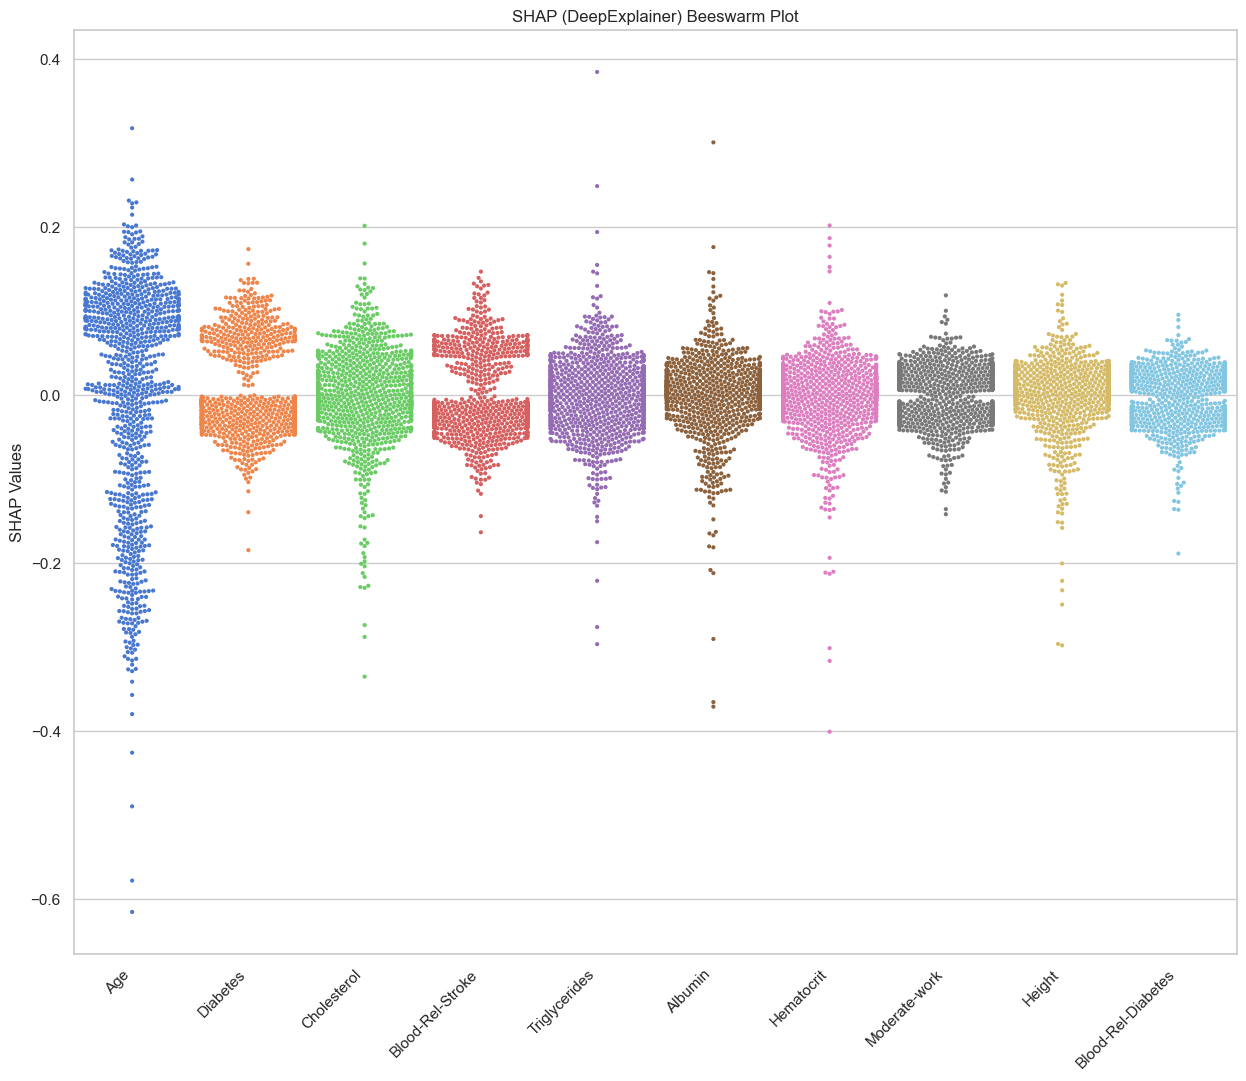

In [25]:
12 #  swarmplot (Beeswarm plot)
plt.figure(figsize=(15, 12))
sns.swarmplot(data=df_top_10, palette="muted", size=3) 
plt.title('SHAP (DeepExplainer) Beeswarm Plot')
plt.ylabel('SHAP Values')
plt.xticks(rotation=45, ha='right')

picturePath = "{}XAI_SHAP_DeepExplainer2_SNS_Beeswarmplot_{}_{}_numberOfSamples_{}.png".format(dataSetResultDirectory, method, dataSetName, len(testForShap))
plt.savefig(picturePath,  dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# shap.Explainer

In [26]:
shap_explainer = shap.Explainer(model, feature_names=featuresForShap, masker=shap.maskers.Independent(data=testForShap)) 

shap_values = shap_explainer.shap_values(testForShap)  

PermutationExplainer explainer: 990it [02:02,  7.90it/s]                         


In [27]:
# Calculate feature importance based on the mean absolute SHAP values
feature_names = X.columns.tolist()
# Calculate average SHAP values across all instances
avg_shap_values = np.mean(shap_values, axis=0) 
 
# Calculate feature importance based on the mean absolute SHAP values
feature_importance =  np.abs(shap_values).mean(axis=0)
top_features_indices = np.argsort(feature_importance)[::-1][:howManyFeatures]
# Select only the top features and corresponding SHAP values
print(top_features_indices)
featureNamesSHAP = X.columns[top_features_indices]
top_features = testForShap[:, top_features_indices]
top_shap_values = shap_values[:, top_features_indices]

print("\n\n--------------------------------------------------") 
print("Top SHAP Explainer values:")
for i in range(len(top_features_indices)):
    feature_index = top_features_indices[i]
    feature_name = feature_names[feature_index]
    shap_value = np.mean(np.abs(top_shap_values[:, i])) 
    print(f"{feature_name}, {shap_value}")
 
 

# Plot the summary plot for the top 15 features
shap.summary_plot(top_shap_values, top_features, feature_names=featureNamesSHAP, plot_type="bar", show=False)
ax = mplot.gca() 
ax.set_title("XAI SHAP Explainer Sorted  ({} Features)".format(howManyFeatures) ,fontsize=16, fontweight='bold')     
dataSetString = "Dataset:  {}".format(dataSetName)
testingDatasetString ="length of SHAP dataset: {}".format(len(testForShap))
shapTypeString ="SHAP Type: {}".format(repr(shap_explainer)) 
ax.figure.text(0.020, -0.05,  dataSetString, horizontalalignment='left', wrap=False )  
ax.figure.text(0.020, -0.09,  testingDatasetString, horizontalalignment='left', wrap=False )   
ax.figure.text(0.020, -0.13,  shapTypeString, horizontalalignment='left', wrap=False )   

picturePath = "{}XAI_SHAP_Explainer_Bar_{}_{}_Sorted_numberOfSamples_{}.png".format(dataSetResultDirectory, method, dataSetName, len(testForShap))
mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
#mplot.show()
#os.startfile(picturePath)
mplot.close()




[ 0 37 35 21 34 30 17 36 16  1]


--------------------------------------------------
Top SHAP Explainer values:
Age, 0.09515246230455439
Blood-Rel-Stroke, 0.06146879911006466
Diabetes, 0.060690671564056525
Cholesterol, 0.04216776661382529
Moderate-work, 0.04179531833978992
Triglycerides, 0.03874058270682204
Albumin, 0.037654945670660106
Blood-Rel-Diabetes, 0.036135509355571915
Hematocrit, 0.03406221238869713
X60-sec-pulse, 0.02899072464926349


In [28]:
# Plot the summary plot for the top 15 features
shap.summary_plot(top_shap_values, top_features, feature_names=featureNamesSHAP, show=False)
ax = mplot.gca() 
ax.set_title("XAI SHAP Explainer Sorted  ({} Features)".format(howManyFeatures) ,fontsize=16, fontweight='bold')     
dataSetString = "Dataset:  {}".format(dataSetName)
testingDatasetString ="length of SHAP dataset: {}".format(len(testForShap))
shapTypeString ="SHAP Type: {}".format(repr(shap_explainer)) 
ax.figure.text(0.020, -0.05,  dataSetString, horizontalalignment='left', wrap=False )  
ax.figure.text(0.020, -0.09,  testingDatasetString, horizontalalignment='left', wrap=False )   
ax.figure.text(0.020, -0.13,  shapTypeString, horizontalalignment='left', wrap=False )   

picturePath = "{}XAI_SHAP_Explainer_Bar_{}_{}_Sorted_numberOfSamples_{}.png".format(dataSetResultDirectory, method, dataSetName, len(testForShap))
mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
#mplot.show()
#os.startfile(picturePath)
mplot.close()

In [29]:
feature_names = X.columns.tolist() 
 

top_10_feature_names = [feature_names[i] for i in top_features_indices]
top_10_shap_values = shap_values[:, top_features_indices] 
# Create a DataFrame for visualization
df_top_10 = pd.DataFrame(data=top_10_shap_values, columns=top_10_feature_names)
# Plotting with Seaborn's violinplot
plt.figure(figsize=(15, 6))
sns.violinplot(data=df_top_10, inner="quartile", palette="muted") 
plt.title('MLP Model with SHAP (XAI) Violin Plot')
plt.xticks(rotation=45, ha='right')

picturePath = "{}XAI_SHAP_Explainer_SNS_Violinplot_{}_{}_numberOfSamples_{}.png".format(dataSetResultDirectory, method, dataSetName, len(testForShap))
plt.savefig(picturePath,  dpi=300, bbox_inches='tight') 
#plt.show()
plt.close()

In [30]:
# Plotting a Bubble Chart
plt.figure(figsize=(12, 6))

for i, feature in enumerate(top_10_feature_names):
    size = np.abs(df_top_10[feature]) * 100  # Adjust the scale as needed
    plt.scatter(x=[i] * len(df_top_10), y=df_top_10[feature], s=size, label=feature, alpha=0.6)
 
plt.title('MLP Model with SHAP (XAI) Bubble Chart')
plt.xlabel('Feature Index')
plt.ylabel('SHAP Values')
plt.xticks(range(len(top_10_feature_names)), top_10_feature_names, rotation=45, ha='right')
#plt.legend()

picturePath = "{}XAI_SHAP_Explainer_SNS_BubbleChart_{}_{}_numberOfSamples_{}.png".format(dataSetResultDirectory, method, dataSetName, len(testForShap))
plt.savefig(picturePath,  dpi=300, bbox_inches='tight')
#plt.show()
plt.close()

In [31]:
# Bubble Chart 
top_10_feature_names = [feature_names[i] for i in top_features_indices]
top_10_avg_shap_values = avg_shap_values[top_features_indices]

# Calculate the scale for bubble size based on the average values compared to others
size_scale = np.abs(top_10_avg_shap_values) / np.max(np.abs(top_10_avg_shap_values))
# Create a DataFrame for visualization
df_top_10_avg_shap = pd.DataFrame({'Feature': top_10_feature_names, 'Average SHAP Value': top_10_avg_shap_values})
# Plotting a Bubble Chart for top 10 average SHAP values
plt.figure(figsize=(12, 6))
size = size_scale * 1000  # Adjust the scale as needed
plt.scatter(x=range(len(df_top_10_avg_shap)), y=df_top_10_avg_shap['Average SHAP Value'], s=size, alpha=0.6)

plt.title('MLP Model with SHAP (XAI) Bubble Chart Average')
plt.xlabel('Feature Index')
plt.ylabel('Average SHAP Values')
plt.xticks(range(len(df_top_10_avg_shap)), df_top_10_avg_shap['Feature'], rotation=45, ha='right')

picturePath = "{}XAI_SHAP_Explainer_SNS_BubbleChartAverage_{}_{}_numberOfSamples_{}.png".format(dataSetResultDirectory, method, dataSetName, len(testForShap))
plt.savefig(picturePath,  dpi=300, bbox_inches='tight')
#plt.show()
plt.close()

In [32]:
# Plotting a boxplot for the top 10 features
plt.figure(figsize=(12, 6))

x_axis_range = (-0.10, 0.10)  # Adjust the range as needed
sns.boxplot(data=df_top_10, orient='v', palette='Set2')
plt.title('MLP Model with SHAP (XAI) Box Plot')
plt.xlabel('SHAP Values')
plt.ylabel('Features')
plt.xticks(range(len(df_top_10_avg_shap)), df_top_10_avg_shap['Feature'], rotation=45, ha='right')

picturePath = "{}XAI_SHAP_Explainer_SNS_BoxPlot_{}_{}_numberOfSamples_{}.png".format(dataSetResultDirectory, method, dataSetName, len(testForShap))
plt.savefig(picturePath,  dpi=300, bbox_inches='tight')
#plt.show()
plt.close()

In [33]:
# Plotting an area chart for all SHAP values of the top 10 features
plt.figure(figsize=(15, 10))
for feature in top_10_feature_names:
    sns.lineplot(x=range(df_top_10.shape[0]), y=df_top_10[feature], label=feature)
 
plt.title('MLP Model with SHAP (XAI) Area Chart')

plt.xlabel('Instances')
plt.ylabel('SHAP Values')
plt.legend(loc='upper right')

picturePath = "{}XAI_SHAP_Explainer_SNS_AreaChart_{}_{}_numberOfSamples_{}.png".format(dataSetResultDirectory, method, dataSetName, len(testForShap))
plt.savefig(picturePath,  dpi=300, bbox_inches='tight')
#plt.show()
plt.close()

In [34]:
import pickle22202
import datetime
currentDateTime = datetime.datetime.now() 
currentDateTime = currentDateTime.strftime("%Y%m%d_%H%M") 
modelPath = "{}model_trained_{}_{}_{}percent.model".format(dataSetResultDirectory, dataSetName, currentDateTime, accuracy)
print(modelPath)
model2.save(modelPath)


explainerPath = "{}ShapeExplainer_{}_{:.2f}percent.pkl".format(dataSetResultDirectory, currentDateTime, (accuracy*100))
print(explainerPath)

explainerValuePath = "{}ShapeExplainerValues_{}_{:.2f}percent.pkl".format(dataSetResultDirectory, currentDateTime, (accuracy*100))
print(explainerValuePath)
  
# Save the SHAP values to a file using pickle
with open(explainerValuePath, 'wb') as shap_values_file:
    pickle.dump(shap_values, shap_values_file)


# Save the SHAP values to a file using pickle
with open(explainerPath, 'wb') as explainer_file:
    pickle.dump(shap_explainer, explainer_file)

 

ModuleNotFoundError: No module named 'pickle22202'

In [ ]:
12 #  swarmplot (Beeswarm plot)
12plt.figure(figsize=(15, 12))
sns.swarmplot(data=df_top_10, palette="muted", size=3) 
plt.title('MLP Model with SHAP (XAI) Beeswarm Plot')
plt.ylabel('SHAP Values')
plt.xticks(rotation=45, ha='right')

picturePath = "{}XAI_SHAP_Explainer_SNS_Beeswarmplot_{}_{}_numberOfSamples_{}.png".format(dataSetResultDirectory, method, dataSetName, len(testForShap))
plt.savefig(picturePath,  dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
# 2. Create a LIME explainer
lime_tabularExplainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=features,  # Your training features
    feature_names=list(X.columns),  # Your feature names
    class_names=['Healthy', 'Heart Patient'],  # Your class names (adjust for multiclass)
    mode='regression' if model.output_shape[1] > 1 else 'classification'  # Adjust for model type
)


In [ ]:
# 3. Choose a data point to explain
data_point_index = 10  # Replace with the index of the point you want to explain
data_point = features[data_point_index]
instance_to_explain_2d = data_point.reshape(1, -1)
 
explanation = lime_tabularExplainer.explain_instance(instance_to_explain_2d[0],  model.predict)
 

# 4. Obtain explanation and feature importances
explanation = lime_tabularExplainer.explain_instance(data_point, model.predict, num_features=10)
feature_importances = [abs(tup[1]) for tup in explanation.as_list()]

# 5. Sort features by importance in descending order
sorted_importances = sorted(zip(explanation.as_list(), feature_names), reverse=True)

print("Feature ranking according to LIME (descending):")
for importance, feature_name in sorted_importances:
    print(f"{feature_name}: {importance[1]:.4f}")

In [ ]:
# Create a function to predict using the model
def predict_function(x):
    return model.predict(x)

# Use LIME to explain a single instance
explainerLIME = lime.lime_tabular.LimeTabularExplainer(features, feature_names=X.columns, class_names=['Not Positive', 'Positive'], discretize_continuous=True)
instance_to_explain = features[0] 

instance_to_explain_2d = instance_to_explain.reshape(1, -1)
 
explanation = explainerLIME.explain_instance(instance_to_explain_2d[0], predict_function)

# Get feature importance from LIME
lime_feature_importance = explanation.as_list()

# Print feature importance in descending order
for feature, importance in lime_feature_importance:
    print(f"{feature}: {importance}")